# AML Project: Skincare Product Recommendation System
Dataset: [Sephora Product Review](https://www.kaggle.com/datasets/nadyinky/sephora-products-and-skincare-reviews)

In [3]:
! kaggle datasets download nadyinky/sephora-products-and-skincare-reviews

Dataset URL: https://www.kaggle.com/datasets/nadyinky/sephora-products-and-skincare-reviews
License(s): Attribution 4.0 International (CC BY 4.0)
 96% 141M/147M [00:01<00:00, 94.6MB/s]
100% 147M/147M [00:01<00:00, 89.5MB/s]


In [4]:
! unzip sephora-products-and-skincare-reviews.zip
! rm -rf sephora-products-and-skincare-reviews.zip

Archive:  sephora-products-and-skincare-reviews.zip
  inflating: product_info.csv        
  inflating: reviews_0-250.csv       
  inflating: reviews_1250-end.csv    
  inflating: reviews_250-500.csv     
  inflating: reviews_500-750.csv     
  inflating: reviews_750-1250.csv    


## EDA for Recommendation

In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
from tqdm import tqdm

In [9]:
products = pd.read_csv("product_info.csv")
products.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8494 entries, 0 to 8493
Data columns (total 27 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   product_id          8494 non-null   object 
 1   product_name        8494 non-null   object 
 2   brand_id            8494 non-null   int64  
 3   brand_name          8494 non-null   object 
 4   loves_count         8494 non-null   int64  
 5   rating              8216 non-null   float64
 6   reviews             8216 non-null   float64
 7   size                6863 non-null   object 
 8   variation_type      7050 non-null   object 
 9   variation_value     6896 non-null   object 
 10  variation_desc      1250 non-null   object 
 11  ingredients         7549 non-null   object 
 12  price_usd           8494 non-null   float64
 13  value_price_usd     451 non-null    float64
 14  sale_price_usd      270 non-null    float64
 15  limited_edition     8494 non-null   int64  
 16  new   

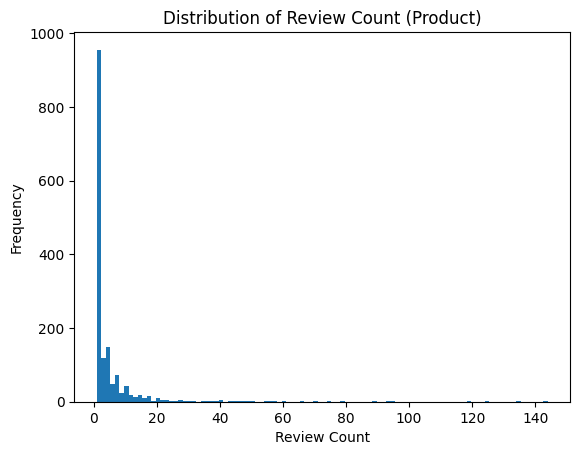

In [10]:
products["reviews"].value_counts().plot(kind="hist", bins=100)
plt.title("Distribution of Review Count (Product)")
plt.xlabel("Review Count")
plt.ylabel("Frequency")
plt.show()

In [11]:
data_dir = Path("./")
reviews = pd.DataFrame()
for file in data_dir.iterdir():
    if str(file).startswith("reviews"):
        reviews = pd.concat([reviews, pd.read_csv(file, index_col=0)])
        print(f"Loaded {file}")
reviews.shape

Loaded reviews_500-750.csv


<ipython-input-11-9b5af564ffd9>:5: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  reviews = pd.concat([reviews, pd.read_csv(file, index_col=0)])


Loaded reviews_0-250.csv


<ipython-input-11-9b5af564ffd9>:5: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  reviews = pd.concat([reviews, pd.read_csv(file, index_col=0)])


Loaded reviews_1250-end.csv


<ipython-input-11-9b5af564ffd9>:5: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  reviews = pd.concat([reviews, pd.read_csv(file, index_col=0)])


Loaded reviews_750-1250.csv
Loaded reviews_250-500.csv


(1094411, 18)

In [12]:
user_action = reviews.groupby("author_id")["product_id"].count().sort_values(ascending=False)
user_action.head()

,product_id
author_id,
1696370280,234
1288462295,171
5060164185,132
2330399812,131
7375781965,130


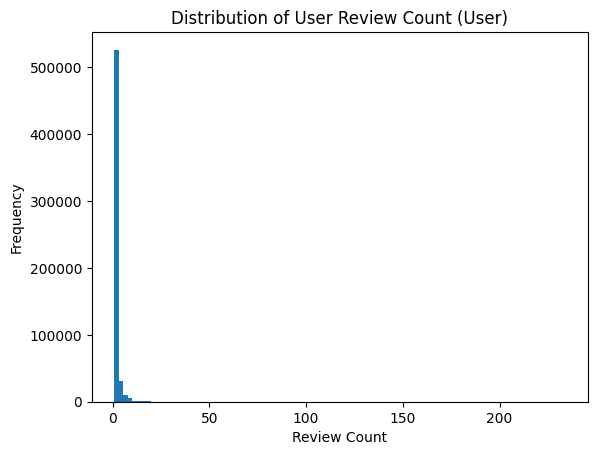

In [13]:
import matplotlib.pyplot as plt

user_action.plot(kind="hist", bins=100)
plt.title("Distribution of User Review Count (User)")
plt.xlabel("Review Count")
plt.ylabel("Frequency")
plt.show()

## Recommendation System
- Content-base filtering: similarity between products
- Collaborative filtering: matrix (Insufficient data info, lack user info)
factorization

Packages:
- [Suprise](https://surprise.readthedocs.io/en/stable/index.html)
- [Implicit](https://benfred.github.io/implicit/index.html)
- [LightFM](https://making.lyst.com/lightfm/docs/index.html)

In [14]:
! pip install scikit-surprise implicit lightfm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.4/154.4 kB 5.7 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 316.4/316.4 kB 19.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.9/8.9 MB 100.6 MB/s eta 0:00:00
  Created wheel for scikit-surprise: filename=scikit_surprise-1.1.4-cp310-cp310-linux_x86_64.whl size=2357274 sha256=8670a75290063dc2d278303d2e798bf76157025dd7d0b167099e55fce898de11
  Stored in directory: /root/.cache/pip/wheels/4b/3f/df/6acbf0a40397d9bf3ff97f582cc22fb9ce66adde75bc71fd54
  Created wheel for lightfm: filename=lightfm-1.17-cp310-cp310-linux_x86_64.whl size=806103 sha256=825a77f70e0824f6766ce1d2e0a3e51f433196eac5c84c85c12f68cd241a8624
  Stored in directory: /root/.cache/pip/wheels/4f/9b/7e/0b256f2168511d8fa4dae4fae0200fdbd729eb424a912ad636
Successfully built sc

In [15]:
# Hyper-parameters
LOYAL_THRESHOLD = 15
TEST_RATIO = 0.2
EVAL_K = [3, 5, 8, 10]

In [16]:
loyal_user = user_action[user_action >= LOYAL_THRESHOLD]
loyal_user

,product_id
author_id,
1696370280,234
1288462295,171
5060164185,132
2330399812,131
7375781965,130
...,...
973401337,15
9231806898,15
2557532236,15


In [17]:
df = reviews.query("author_id in @loyal_user.index")
df.shape

(90608, 18)

In [18]:
def viz(precisions, recalls, EVAL_K, title):
    plt.figure(figsize=(10, 6))
    plt.plot(EVAL_K, precisions, label='Precision', marker='o')
    plt.plot(EVAL_K, recalls, label='Recall', marker='o')
    plt.ylim(0, 1.05)
    plt.xlabel('k')
    plt.ylabel('Score')
    plt.title(title)
    plt.legend()
    plt.grid(True)
    return plt

def viz_hyperparams(combinations, metrics, title):
    plt.figure(figsize=(10, 6))
    plt.scatter(np.arange(len(combinations)), metrics, marker='o')
    plt.xticks(np.arange(len(combinations)), [str(combo) for combo in combinations], rotation=30)
    plt.xlabel('Hyperparameters')
    plt.ylabel('Score')
    plt.title(title)
    plt.grid(True)
    return plt

In [26]:
def hyperparam_combination(d):
    keys = d.keys()
    values = d.values()
    return [dict(zip(keys, combo)) for combo in product(*values)]

### Collaborative Filtering: Explicit Rating

In [20]:
from collections import defaultdict
from itertools import product

from surprise import Dataset, Reader
from surprise import SVD
from surprise.model_selection import train_test_split, cross_validate
from surprise import accuracy

In [21]:
CONFIG_DICT1 = {
    "n_factors": [50, 100, 150]
}

In [22]:
# Define a Reader to interpret the DataFrame
reader = Reader(rating_scale=(1, 5))  # Specify the rating scale
surprise_data = Dataset.load_from_df(df[['author_id', 'product_id', 'rating']], reader)

In [23]:
trainset, testset = train_test_split(surprise_data, test_size=TEST_RATIO, random_state=42)

In [24]:
# size of training & testing set
np.sum([len(v) for v in trainset.ur.values()]), len(testset)

(72486, 18122)

In [27]:
combinations1 = hyperparam_combination(CONFIG_DICT1)

rmse_scores = []
best_model = None
best_rmse = float('inf')

for args in tqdm(combinations1):
    algo = SVD(**args)
    algo.fit(trainset)
    predictions = algo.test(testset)
    rmse = accuracy.rmse(predictions)
    rmse_scores.append(rmse)
    if rmse < best_rmse:
        best_rmse = rmse
        best_model = algo

 33%|███▎      | 1/3 [00:03<00:06,  3.31s/it]

RMSE: 0.7046


 67%|██████▋   | 2/3 [00:08<00:04,  4.30s/it]

RMSE: 0.7053


100%|██████████| 3/3 [00:11<00:00,  3.75s/it]

RMSE: 0.7079


In [28]:
algo = best_model
pred = algo.test(testset)
rmse = accuracy.rmse(pred)
mse = accuracy.mse(pred)
fcp = accuracy.fcp(pred)
mae = accuracy.mae(pred)

RMSE: 0.7046
MSE: 0.4964
FCP:  0.5515
MAE:  0.4396


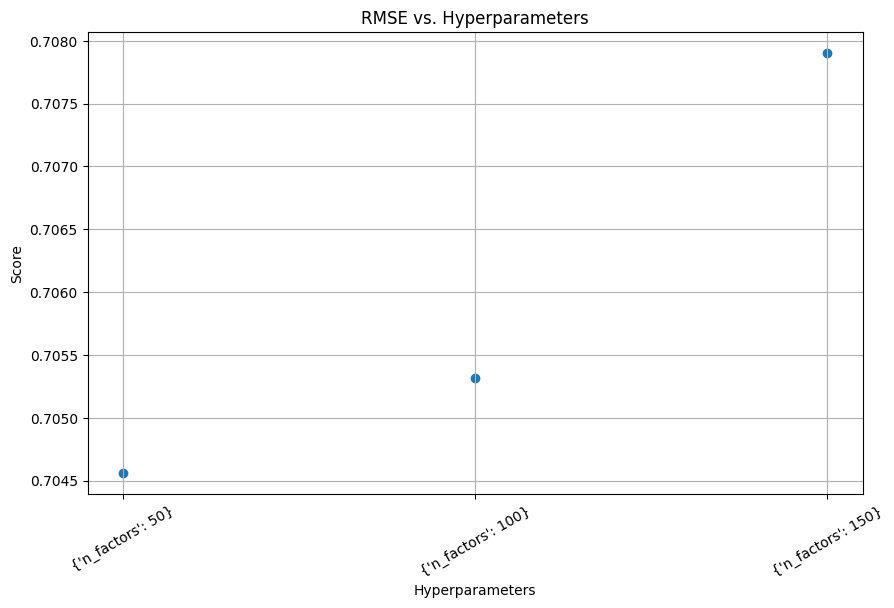

In [29]:
viz_hyperparams(combinations1, rmse_scores, "RMSE vs. Hyperparameters").show()

In [30]:
def precision_recall_at_k_explicit(predictions, k, threshold=3.5):
    """
    Compute Precision@k and Recall@k for all users.

    Parameters:
    - predictions: List of predictions, as returned by the Surprise test method.
    - k: Number of top recommendations to consider (top-k).
    - threshold: Threshold for considering a rating as relevant.

    Returns:
    - precisions: Dict of Precision@k for each user.
    - recalls: Dict of Recall@k for each user.
    """
    # Map the predictions to each user
    user_est_true = defaultdict(list)
    for uid, iid, true_r, est, _ in predictions:
        user_est_true[uid].append((est, true_r))

    precisions = {}
    recalls = {}

    for uid, user_ratings in user_est_true.items():
        # Sort user ratings by estimated score
        user_ratings.sort(key=lambda x: x[0], reverse=True)

        # Get the top-k items
        top_k = user_ratings[:k]

        # Number of relevant items in top-k
        n_rel_and_rec_k = sum((true_r >= threshold) for (_, true_r) in top_k)

        # Number of relevant items for the user
        n_rel = sum((true_r >= threshold) for (_, true_r) in user_ratings)

        # Precision@k: Proportion of recommended items in top-k that are relevant
        precisions[uid] = n_rel_and_rec_k / k if k > 0 else 0

        # Recall@k: Proportion of relevant items that are recommended in top-k
        recalls[uid] = n_rel_and_rec_k / n_rel if n_rel > 0 else 0

    # Return average Precision@k and Recall@k
    avg_precision = np.mean(list(precisions.values()))
    avg_recall = np.mean(list(recalls.values()))

    return avg_precision, avg_recall

In [31]:
# Make predictions
predictions = algo.test(testset)

# Compute Precision@k and Recall@k
precision_explicit, recall_explicit = [], []
for k in EVAL_K:
    precision, recall = precision_recall_at_k_explicit(predictions, k)
    precision_explicit.append(precision)
    recall_explicit.append(recall)

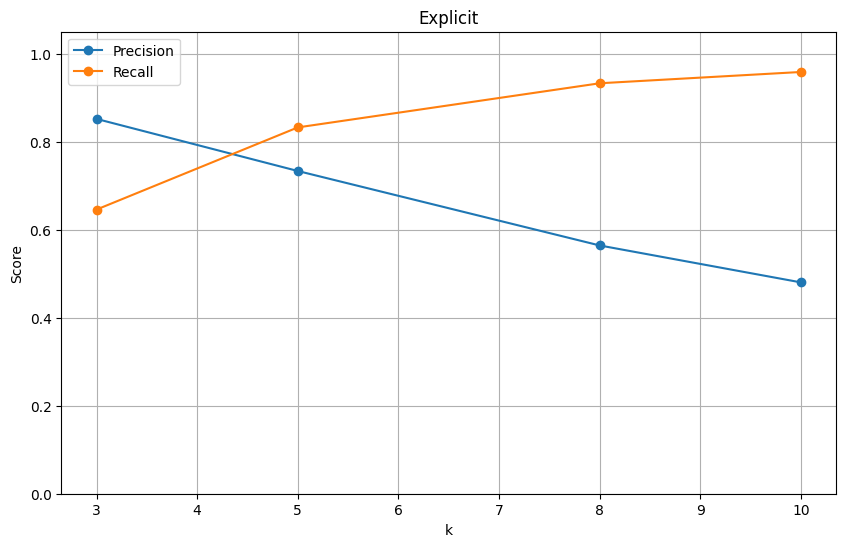

In [32]:
viz(precision_explicit, recall_explicit, EVAL_K, "Explicit").show()

### Collaborative Filtering: Implicit Feedback

In [33]:
import implicit
import numpy as np
from scipy.sparse import csr_matrix
from sklearn.model_selection import train_test_split
from scipy.sparse import csr_matrix

In [34]:
ITER = 20
CONFIG_DICT2 = {
    "factors": [20, 30, 50],
    "regularization": [0.01, 0.1],
}

In [35]:
interaction_matrix = df.pivot_table(index='author_id', columns='product_id', values='is_recommended', fill_value=0)
interaction_matrix.head()

product_id,P107306,P114902,P12045,P122651,P122661,P122718,P122762,P122767,P122774,P122876,...,P54509,P6028,P7365,P7880,P91627362,P94421,P94812,P9939,P9940,P9941
author_id,,,,,,,,,,,,,,,,,,,,,
1048276344,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1186055472,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
1288462295,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1330750144,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1454405898,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [36]:
def hide_interactions(matrix, test_fraction=0.2):
    """
    Splits the interaction matrix into training and test sets by hiding
    a fraction of interactions for each user in the test set.

    Args:
        matrix (csr_matrix): User-item interaction matrix.
        test_fraction (float): Fraction of interactions to hide.

    Returns:
        train_matrix (csr_matrix): Training matrix with hidden interactions removed.
        test_matrix (csr_matrix): Test matrix with hidden interactions.
    """
    train_matrix = matrix.copy()
    test_matrix = csr_matrix(matrix.shape, dtype=matrix.dtype)

    # Iterate through each user
    for user in range(matrix.shape[0]):
        user_interactions = matrix[user].indices
        user_interactions_count = len(user_interactions)

        # Determine the number of interactions to hide
        n_test = int(np.ceil(user_interactions_count * test_fraction))

        if n_test == 0:
            continue  # Skip if no interactions to hide

        # Randomly select indices to hide
        hidden_indices = np.random.choice(user_interactions, size=n_test, replace=False)

        # Hide these interactions in the training set
        train_matrix[user, hidden_indices] = 0

        # Add hidden interactions to the test set
        test_matrix[user, hidden_indices] = matrix[user, hidden_indices]

    # Remove explicit zeros to maintain sparsity
    train_matrix.eliminate_zeros()
    test_matrix.eliminate_zeros()

    return train_matrix, test_matrix

interaction_matrix = csr_matrix(interaction_matrix)
train_matrix, test_matrix = hide_interactions(interaction_matrix, test_fraction=TEST_RATIO)
train_matrix.shape, test_matrix.shape

/usr/local/lib/python3.10/dist-packages/scipy/sparse/_index.py:142: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray_sparse(i, j, x)


((3182, 1685), (3182, 1685))

In [37]:
def recommend_pred(model, train_matrix, k=10):
    # Calculate the confidence for each item
    user_recommendations = {}
    for user_id in range(train_matrix.shape[0]):
        recommendations = model.recommend(user_id, train_matrix[user_id], N=max(EVAL_K))
        user_recommendations[user_id] = [item[0] for item in recommendations]
    return user_recommendations

def ndcg_at_k(model, test_matrix, k):
    ndcg_scores = []
    recommendations = recommend_pred(model, train_matrix, k)

    for user_id in range(test_matrix.shape[0]):
        relevant_items = test_matrix[user_id].indices
        top_k_recommendations = recommendations[user_id][:k]

        # Compute DCG
        dcg = sum([1 / np.log2(i + 2) for i, item in enumerate(top_k_recommendations) if item in relevant_items])

        # Compute IDCG (ideal DCG)
        ideal_relevant_count = min(len(relevant_items), k)
        idcg = sum([1 / np.log2(i + 2) for i in range(ideal_relevant_count)])

        ndcg_scores.append(dcg / idcg if idcg > 0 else 0)

    return np.mean(ndcg_scores)

In [38]:
combinations2 = hyperparam_combination(CONFIG_DICT2)
k = max(EVAL_K)
ndcg_scores = []
best_model = None
best_ndcg = 0.0
for args in tqdm(combinations2):
    model = implicit.als.AlternatingLeastSquares(**args)
    model.fit(train_matrix)
    ndcg = ndcg_at_k(model, test_matrix, k)
    ndcg_scores.append(ndcg)
    if ndcg > best_ndcg:
        best_ndcg = ndcg
        best_model = model

  0%|          | 0/6 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/implicit/cpu/als.py:95: RuntimeWarning: OpenBLAS is configured to use 2 threads. It is highly recommended to disable its internal threadpool by setting the environment variable 'OPENBLAS_NUM_THREADS=1' or by calling 'threadpoolctl.threadpool_limits(1, "blas")'. Having OpenBLAS use a threadpool can lead to severe performance issues here.
  check_blas_config()


  0%|          | 0/15 [00:00<?, ?it/s]

 17%|█▋        | 1/6 [00:01<00:09,  1.88s/it]

  0%|          | 0/15 [00:00<?, ?it/s]

 33%|███▎      | 2/6 [00:03<00:07,  1.90s/it]

  0%|          | 0/15 [00:00<?, ?it/s]

 50%|█████     | 3/6 [00:05<00:05,  1.90s/it]

  0%|          | 0/15 [00:00<?, ?it/s]

 67%|██████▋   | 4/6 [00:07<00:03,  1.92s/it]

  0%|          | 0/15 [00:00<?, ?it/s]

 83%|████████▎ | 5/6 [00:11<00:02,  2.51s/it]

  0%|          | 0/15 [00:00<?, ?it/s]

100%|██████████| 6/6 [00:17<00:00,  2.90s/it]


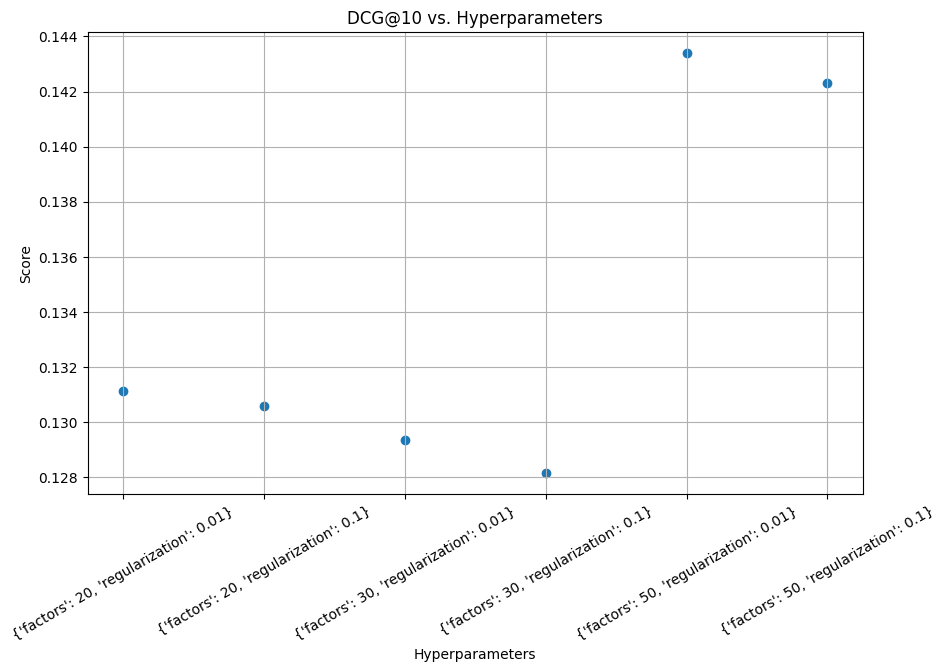

In [39]:
viz_hyperparams(combinations2, ndcg_scores, f"DCG@{k} vs. Hyperparameters").show()

In [40]:
def precision_recall_at_k_implicit(recommendations, test_matrix, k):
    precisions, recalls = [], []

    for user_id in range(test_matrix.shape[0]):
        # Relevant items for this user
        relevant_items = test_matrix[user_id].indices

        # Top-K recommendations for this user

        top_k_recommendations = recommendations[user_id][:k]

        # Compute precision and recall
        relevant_in_top_k = set(relevant_items) & set(top_k_recommendations)
        precision = len(relevant_in_top_k) / k
        recall = len(relevant_in_top_k) / len(relevant_items) if relevant_items.size > 0 else 0

        precisions.append(precision)
        recalls.append(recall)

    return np.mean(precisions), np.mean(recalls)

In [41]:
precision_implicit, recall_implicit = [], []
for k in EVAL_K:
    user_recommendations = recommend_pred(best_model, train_matrix, k)
    precision, recall = precision_recall_at_k_implicit(user_recommendations, test_matrix, k)
    precision_implicit.append(precision)
    recall_implicit.append(recall)

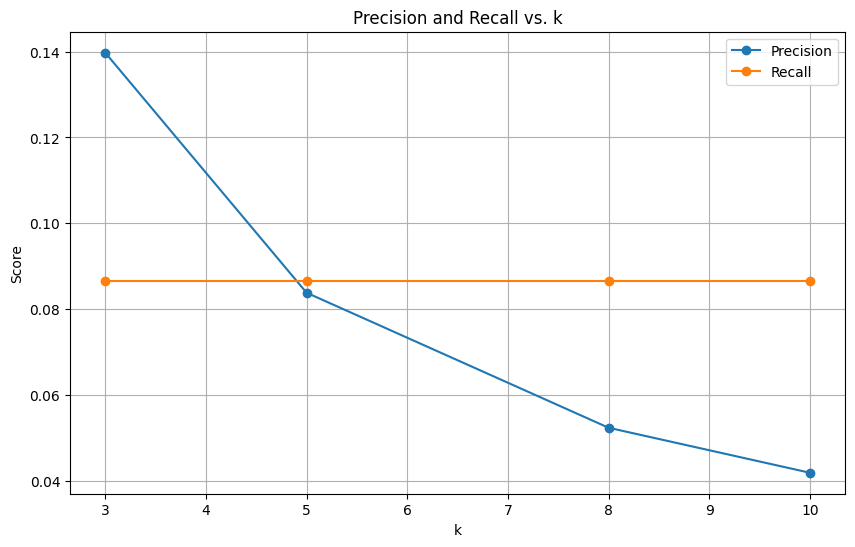

In [42]:
plt.figure(figsize=(10, 6))
plt.plot(EVAL_K, precision_implicit, label='Precision', marker='o')
plt.plot(EVAL_K, recall_implicit, label='Recall', marker='o')
plt.xlabel('k')
plt.ylabel('Score')
plt.title('Precision and Recall vs. k')
plt.legend()
plt.grid(True)

### Collaborative Filtering: Hybrid


In [44]:
import numpy as np
from scipy.sparse import coo_matrix
from lightfm import LightFM
from lightfm.cross_validation import random_train_test_split
from lightfm.evaluation import precision_at_k, recall_at_k, auc_score

In [45]:
EPOCH = 50
CONFIG_DICT3 = {
    "no_components": [10, 20, 30],
    "loss": ["warp", "bpr"],
    "learning_rate": [0.01, 0.001],
}

In [46]:
rating_matrix = df.pivot_table(index='author_id', columns='product_id', values='rating', fill_value=0)
rating_matrix.head()

product_id,P107306,P114902,P12045,P122651,P122661,P122718,P122727,P122762,P122767,P122774,...,P54509,P6028,P7365,P7880,P91627362,P94421,P94812,P9939,P9940,P9941
author_id,,,,,,,,,,,,,,,,,,,,,
1048276344,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1186055472,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0
1288462295,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
1330750144,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
1454405898,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [47]:
# Prepare Interaction Data (User-Item Matrix)
rating_matrix = df.pivot_table(index='author_id', columns='product_id', values='rating', fill_value=0)

# Convert to sparse matrix
interactions = coo_matrix(rating_matrix)

# Use LightFM's random_train_test_split function
train, test = random_train_test_split(interactions, test_percentage=TEST_RATIO, random_state=42)
train.shape, test.shape

((3199, 1700), (3199, 1700))

In [48]:
auc_scores = []
best_model = None
best_auc = 0.0

combinations3 = hyperparam_combination(CONFIG_DICT3)
for args in tqdm(combinations3):
    model = LightFM(**args)
    model.fit(train, epochs=EPOCH, num_threads=4)
    auc = auc_score(model, test).mean()
    auc_scores.append(auc)
    if auc > best_auc:
        best_auc = auc
        best_model = model

100%|██████████| 12/12 [00:59<00:00,  4.98s/it]


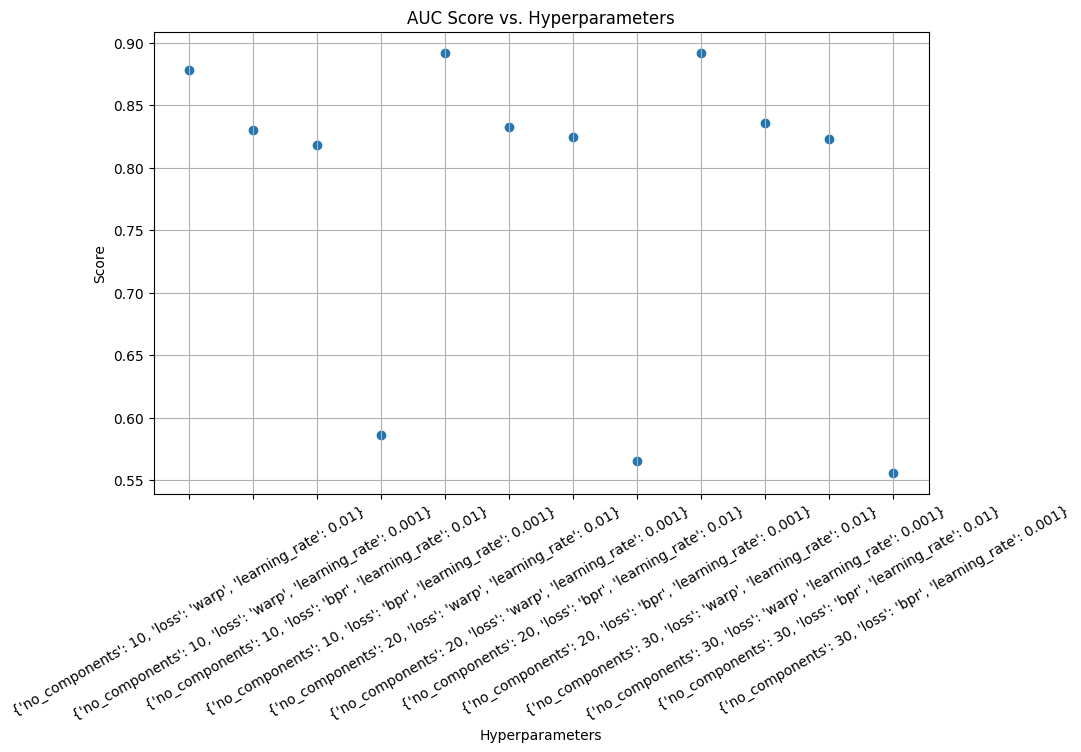

In [49]:
viz_hyperparams(combinations3, auc_scores, "AUC Score vs. Hyperparameters").show()

In [50]:
model = best_model
precision_hybrid, recall_hybrid = [], []
for k in EVAL_K:
    precision = precision_at_k(model, test, k=k).mean()
    recall = recall_at_k(model, test, k=k).mean()
    precision_hybrid.append(precision)
    recall_hybrid.append(recall)

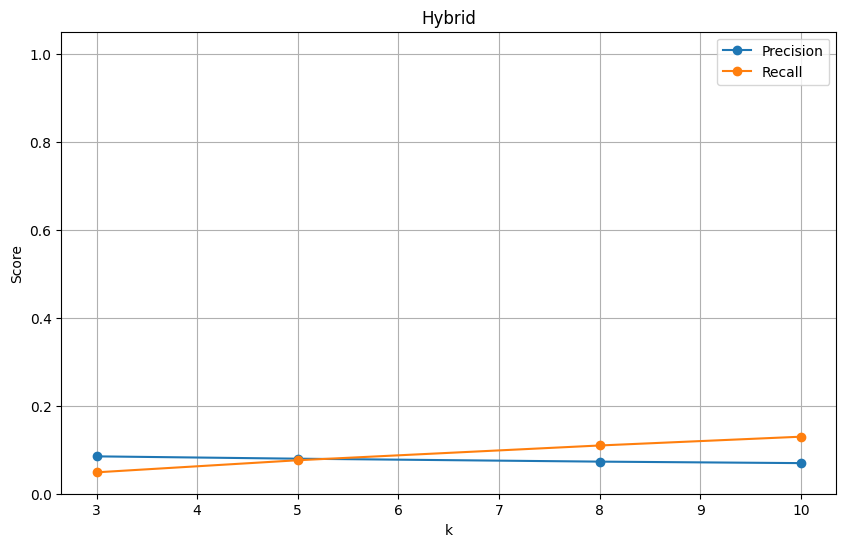

In [52]:
viz(precision_hybrid, recall_hybrid, EVAL_K, "Hybrid").show()

### Model Comparison

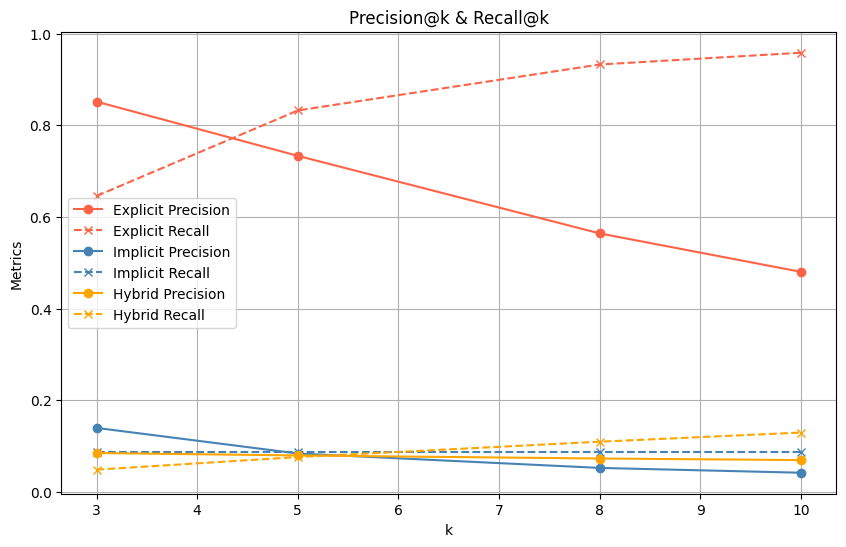

In [60]:
plt.figure(figsize=(10, 6))
plt.plot(EVAL_K, precision_explicit, label='Explicit Precision', marker='o', c="tomato")
plt.plot(EVAL_K, recall_explicit, label='Explicit Recall', marker='x', c="tomato", linestyle='--')
plt.plot(EVAL_K, precision_implicit, label='Implicit Precision', marker='o', c="steelblue")
plt.plot(EVAL_K, recall_implicit, label='Implicit Recall', marker='x', c="steelblue", linestyle='--')
plt.plot(EVAL_K, precision_hybrid, label='Hybrid Precision', marker='o', c="orange")
plt.plot(EVAL_K, recall_hybrid, label='Hybrid Recall', marker='x', c="orange", linestyle='--')
plt.xlabel('k')
plt.ylabel('Metrics')
plt.title('Precision@k & Recall@k')
plt.legend()
plt.grid(True)
plt.show()

### Conclusion
- Increase k, the precision tends to decrease while recall tends to increase
- Explicit method has the best performance